## Variational autoencoder / GAN / SimCLR
- 2 pt: implement and test variational (convolutional) autoencoder or GAN or SimCLR

In [14]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import pickle

In [15]:
## Preliminaries
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu") # uncomment this line to run on CPU
print(device)

## Dataset
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,    
    #transform = transforms.ToTensor(),                     
    download = True           
)
test_data = torchvision.datasets.MNIST(
    root = 'data', 
    train = False, 
    #transform = transforms.ToTensor(),
    download = True
)

label_names=[f'{i}' for i in range(10)]
num_labels = len(label_names)

print(train_data)

cuda
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train


In [16]:
## Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # normalize to [-1, 1]
])

# apply the transforms to the training and test data
train_data.transform = transform
test_data.transform = transform

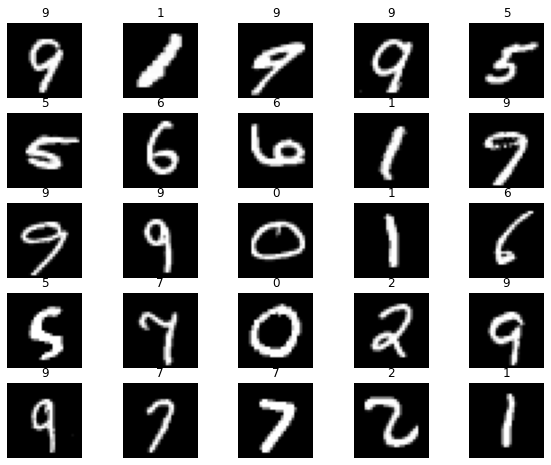

In [17]:
## Data Loader
batch_size = 1024 #go as high as you can without running out of memory
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

look at this https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
consider adding batch normalization to generator and discriminator
consider adding leakyrelu and too discr


In [18]:
## Model definition
p = 0.3 # dropout probability
#consider using 
class Discriminator(nn.Module):
    def __init__(self, ouput_size, fs=64 ): # fs = feature size
        super().__init__()
        ### Convolutional section
        self.discriminator_cnn = nn.Sequential(
            # Convolutional layer 28 -> 14
            nn.Conv2d(in_channels= 1, out_channels=fs, kernel_size=5, 
                      stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(p=p),
            # convolutional layer 14 -> 7
            nn.Conv2d(in_channels=fs, out_channels=2*fs, kernel_size=5, 
                      stride=2, padding=2, bias=False),
            nn.BatchNorm2d(2*fs),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(p=p),
            # Third convolutional layer 7 -> 4
            nn.Conv2d(in_channels=2*fs, out_channels=4*fs, kernel_size=3, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4*fs),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(p=p),
            # Fourth convolutional layer 4 -> 1
            nn.Conv2d(in_channels=4*fs, out_channels=1, kernel_size=3,
                        stride=2, padding=0, bias=False),
            #nn.Dropout(p=p),
            nn.Flatten(start_dim=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.discriminator_cnn(x)
        return x

#consider adding batch normalization to generator 

class Generator(nn.Module):
    def __init__(self, input_size, fs=64): # fs = feature size
        super().__init__()
        self.generator_conv = nn.Sequential(
            ## unflatten
            nn.Unflatten(dim=1, unflattened_size=(input_size, 1, 1)),
            # transposed convolution (1,1) -> (2, 2)
            nn.ConvTranspose2d(in_channels=input_size, out_channels=fs*8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(fs*8),
            nn.LeakyReLU(0.2,True),
            #nn.Dropout(p=p),
            # transposed convolution (2,2) -> (4, 4)
            nn.ConvTranspose2d(in_channels=fs*8, out_channels=fs*4, kernel_size=5, 
                               stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(fs*4),
            nn.LeakyReLU(0.2,True),
            #nn.Dropout(p=p),
            # transposed convolution (4, 4) -> (7, 7)
            nn.ConvTranspose2d(in_channels=fs*4, out_channels=fs*2, kernel_size=5, 
                               stride=2, padding=2, output_padding=0, bias=False),
            nn.BatchNorm2d(fs*2),
            nn.LeakyReLU(0.2,True),
            #nn.Dropout(p=p),
            # transposed convolution (7, 7) -> (14, 14)
            nn.ConvTranspose2d(in_channels=fs*2, out_channels=fs, kernel_size=5,
                                 stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(fs),
            nn.LeakyReLU(0.2,True),
            # nn.Dropout(p=0.5),
            # transposed convolution (14, 14) -> (28, 28)
            nn.ConvTranspose2d(in_channels=fs, out_channels=1, kernel_size=5,
                                    stride=2, padding=2, output_padding=1, bias=False),

        ) 
    def forward(self, x):
        x = self.generator_conv(x)
        x = torch.tanh(x) #tanh for images [-1, 1]
        return x
        

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
torch.manual_seed(42)
noise_size = 20
feature_sizeG = 4
feature_sizeD = 4

#initialize the discriminator and generator
netD = Discriminator(ouput_size=1, fs=feature_sizeD).to(device) #1 for real/fake let's start easy
netG = Generator(input_size=noise_size, fs=feature_sizeG).to(device) #just noise, let's start easy

netD.apply(weights_init)
netG.apply(weights_init)

print("Loaded discriminator and generator")
# print(netD)
# print(netG)

Loaded discriminator and generator


In [20]:
## testing I/O
#2 element vector with random noise
noise = torch.randn(batch_size, noise_size, device=device) #1 will be batch_size
# # one hot encoding of label "3"
# label = torch.zeros(batch_size, num_labels, device=device)
# label[:, 3] = 1
# #concatenate noise and label
# input = torch.cat((noise, label), 1)
input = noise #let's start easy
#print input shape
print(f"genrator input shape: {input.shape}")
fake_img = netG(input)
print(f"fake_img shape: {fake_img.shape}")
assert fake_img.shape == (batch_size, 1, 28, 28)
output = netD(fake_img)
print(f"output shape: {output.shape}") #(1, 11) 10 classes + 1 for real/fake
assert output.shape == (batch_size, 1)

genrator input shape: torch.Size([10000, 20])
fake_img shape: torch.Size([10000, 1, 28, 28])
output shape: torch.Size([10000, 1])


Idea for training: 


The best idea is to implement the original paper for GANs https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf, let's be real
other useful links:
- https://developers.google.com/machine-learning/gan/loss
- https://github.com/soumith/ganhacks


In [21]:
def updateD(netD, real_img_batch, fake_img_batch, loss_fn, optimizerD):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Forward pass real batch through D
    output = netD(real_img_batch)
    # Calculate loss on all-real batch
    target = torch.full((b_size, 1), real_target, device=device, dtype=torch.float)
    errD_real = loss_fn(output, target)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Classify all fake batch with D
    output = netD(fake_img_batch.detach())
    # Calculate D's loss on the all-fake batch
    target = torch.full((b_size, 1), fake_target, device=device, dtype=torch.float)
    errD_fake = loss_fn(output, target)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()
    return errD, D_x, D_G_z1

def updateG(netG, fake_img_batch, real_img_batch, loss_fn, mse_loss, optimizerG):
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake_img_batch)
    # Calculate G's loss based on this output
    target = torch.full((b_size, 1), real_target, device=device, dtype=torch.float)
    errG = loss_fn(output, target)
    # Calculate gradients for G
    errG.backward(retain_graph=True)
    D_G_z2 = output.mean().item()

    # experimental: propagate MSE loss between real and fake images
    errG_mse = mse_loss(fake_img_batch, real_img_batch)
    errG_mse.backward()

    # Update G
    optimizerG.step()
    return errG, D_G_z2
    

In [22]:
## Training
torch.manual_seed(42)
#nets
netD = netD.to(device)
netG = netG.to(device)

netG.apply(weights_init)
netD.apply(weights_init)

# learning rate, based on DCGAN paper
g_lr = 0.0001
d_lr = 0.0001
beta1 = 0.5

#loss function
#use minimax loss, basically binary cross entropy
# real_labels = 1, fake_labels = 0
loss_fn = nn.BCELoss() 
#experimental: MSE loss
mse_loss = nn.MSELoss()
real_target = 1
fake_target = 0

#batch of latent vectors to visualize progress
fixed_noise = torch.randn(64,noise_size, device=device)

#optimizers
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=g_lr)
#optimizerD = torch.optim.SGD(netD.parameters(), lr=d_lr, momentum=0.9)
optimizerG = torch.optim.Adam(netG.parameters(), lr=d_lr)

## Training loop
num_epochs = 5
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    netD.train()
    netG.train()
    for i, data in enumerate(train_dataloader, 0):
        # Format batch
        real_img_batch = data[0].to(device)
        b_size = real_img_batch.size(0)
        # Generate batch of latent vectors
        noise = torch.randn(b_size, noise_size, device=device)
        # Generate fake image batch with G
        fake_img_batch = netG(noise)

        ## Train G
        errG, D_G_z2 = updateG(netG, fake_img_batch, real_img_batch, loss_fn, mse_loss, optimizerG)
        
        ## Train D
        errD, D_x, D_G_z1 = updateD(netD, real_img_batch, fake_img_batch, loss_fn, optimizerD)
    
        # # balance training
        # if epoch >= 0:
        #     j = 0
        #     while D_x < 0.6 and j < 2: #if discriminator is too bad, train discriminator more
        #         noise = torch.randn(real_img_batch.size(0), noise_size, device=device)
        #         fake_img_batch = netG(noise)
        #         errD, D_x, D_G_z1 = updateD(netD, real_img_batch, fake_img_batch, loss_fn, optimizerD)
        #         j += 1
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/5][0/6]	Loss_D: 1.4157	Loss_G: 0.5949	D(x): 0.5535	D(G(z)): 0.5551 / 0.5548
[2/5][0/6]	Loss_D: 1.5199	Loss_G: 0.5181	D(x): 0.5560	D(G(z)): 0.5988 / 0.5992
[3/5][0/6]	Loss_D: 1.5773	Loss_G: 0.4762	D(x): 0.5607	D(G(z)): 0.6233 / 0.6248
[4/5][0/6]	Loss_D: 1.5779	Loss_G: 0.4673	D(x): 0.5659	D(G(z)): 0.6280 / 0.6299
[5/5][0/6]	Loss_D: 1.5441	Loss_G: 0.4824	D(x): 0.5706	D(G(z)): 0.6198 / 0.6199


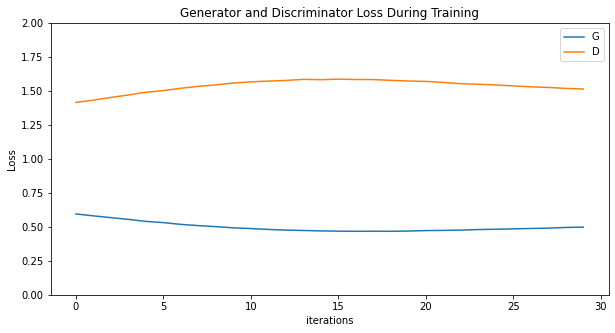

In [23]:
#plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,2)
plt.show()

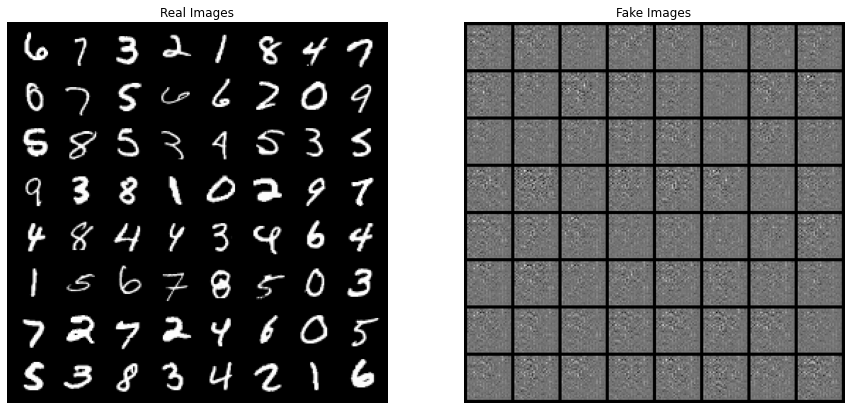

In [24]:
## real vs fake
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [25]:
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

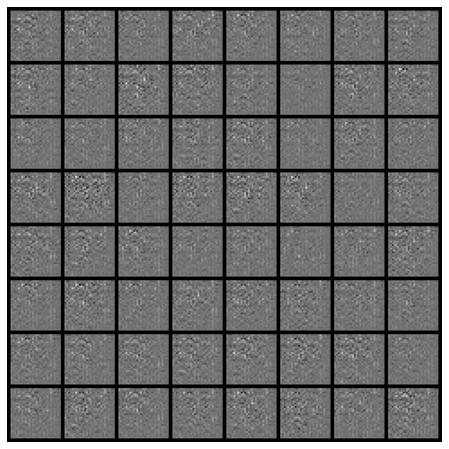

In [26]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### IT TAKES A LOT OF TIME FOR MEANING RESULTS TO SHOW, I WASTED TOO MUCH TIME